<h1>Indholdsfortegnelse<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot, os, dill
import minepy as mp

In [65]:
# Load Data
data_path = "../../data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']
load_variables = "v0_la_mass v0_la_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar pseudorapidity".split(" ")
# load_variables = "v0_rxy v0_chi2 cosTheta v0_ks_mass v0_rxyErr pT ntrk_pv0 a0 calpha a0xy pv0_y".split(" ")

df = data_tree.pandas.df(load_variables, entrystop = 10**3)


In [36]:
# define probability variable
# model_path = "models/data_trained_xg.dat"

# func_seri = dill.load(open(model_path, 'rb'))
# prob_func = dill.loads(func_seri)

In [37]:
import pickle
update_mic_matrix = 0

if update_mic_matrix:
    import minepy
    result = mp.pstats(df.T)
    pickle.dump((result), open("mic_matrix.dat", 'wb'))
else:
    result = pickle.load(open("mic_matrix.dat", 'rb'))

In [38]:
result[0].shape

(1081,)

In [39]:
from scipy.spatial.distance import squareform

mat = squareform(result[0])

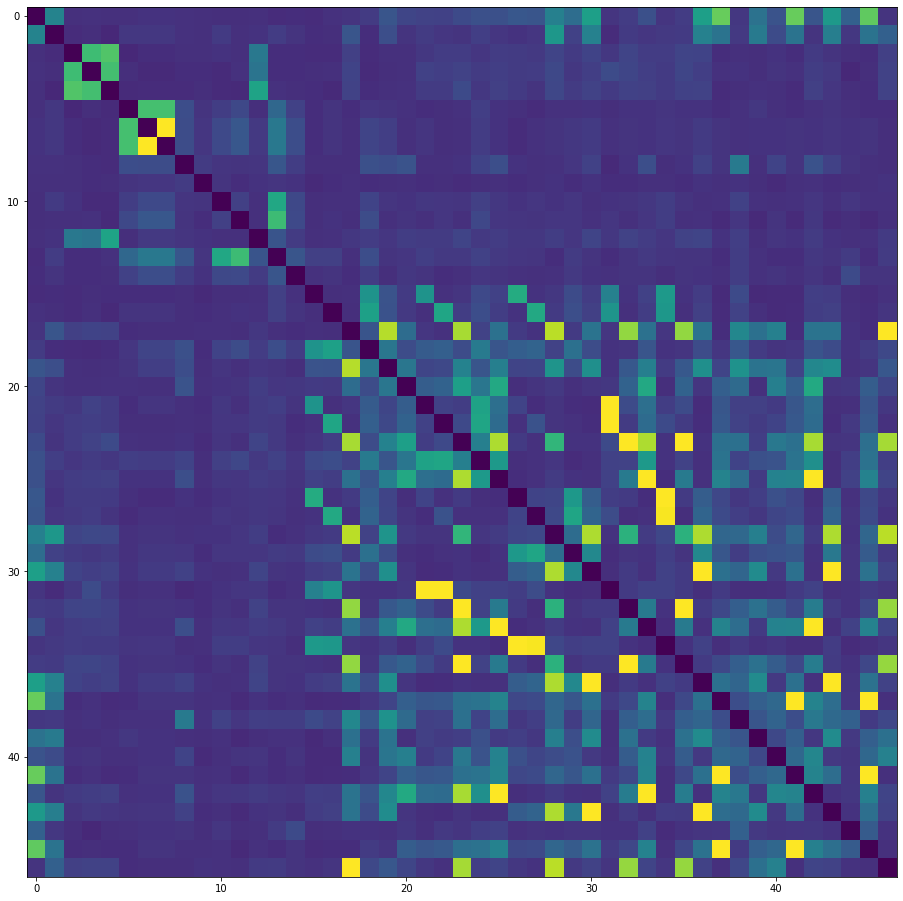

In [40]:
fig, ax = plt.subplots(figsize = (18, 16))
show = ax.imshow(mat) 
cols = df.columns

# for i in range(len(cols)):
#     for j in range(len(cols)):
#         text = ax.text(j, i, np.round(mat[i, j], 2),
#                        ha="center", va="center", color="w")

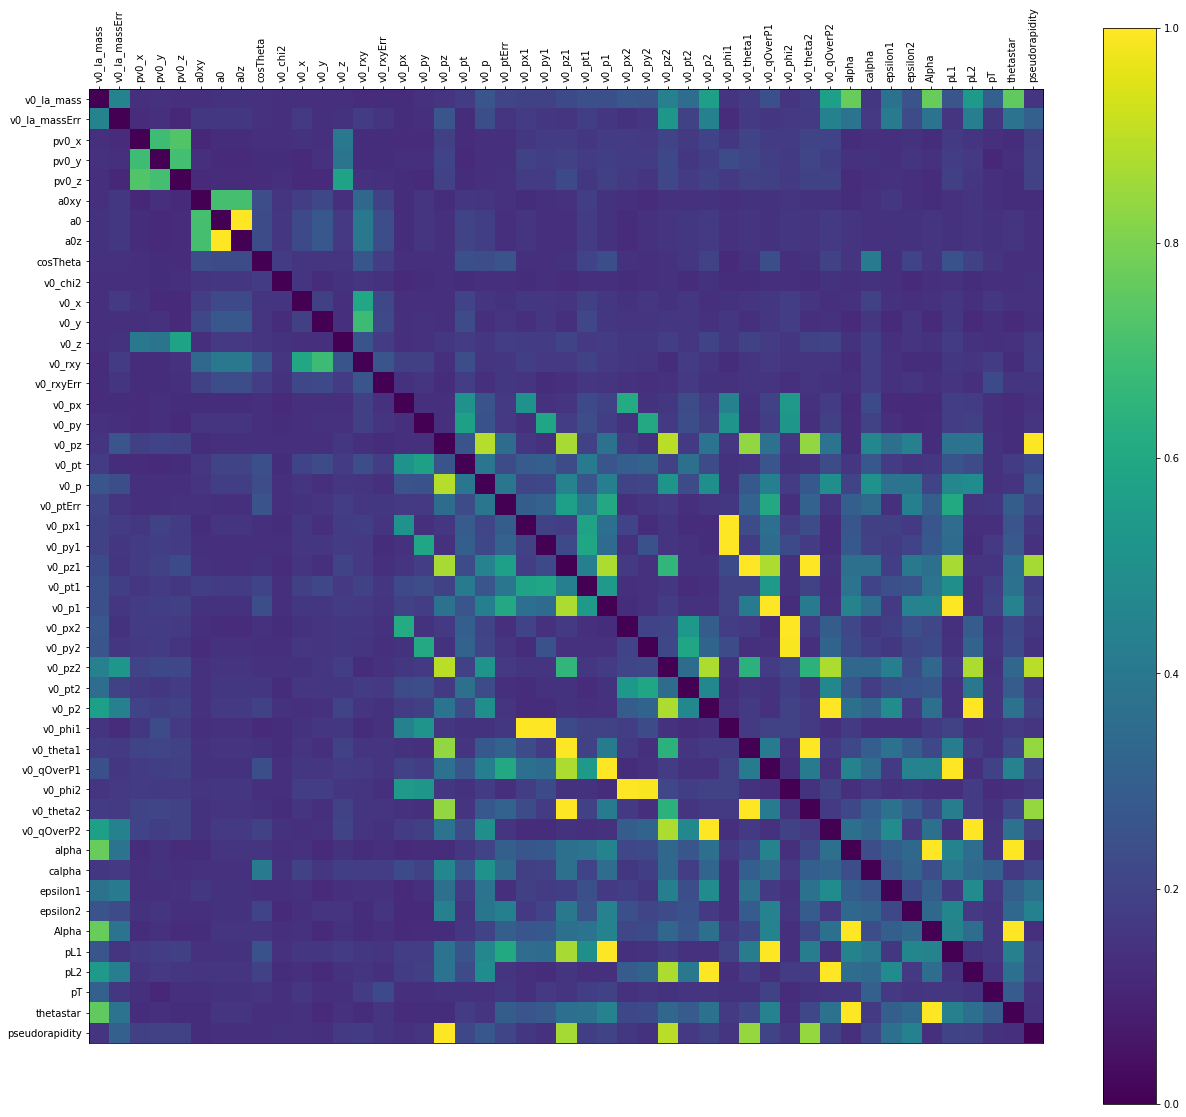

In [41]:
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation = 90)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)
# ax.xticks(rotation = 90)

fig.colorbar(show)

fig.tight_layout()
fig

In [42]:
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import squareform


last = ["v0_la_massErr", "v0_la_mass"]

ind_last = np.array([list(cols).index(par) for par in last])

cols = list(cols)

for i in last:
    try: 
        cols.remove(i)
    except:
        pass
    
saved_rows = mat[:, ind_last]

cut_mat = np.delete(mat, ind_last, axis = 1)
cut_mat = np.delete(cut_mat, ind_last, axis = 0)


dist = squareform(cut_mat)
dist = 1 - dist
dist[dist < 0] = 0


Z = linkage(dist, optimal_ordering = True, method = "average")
sort_ind = leaves_list(optimal_leaf_ordering(Z, dist))

# leaves_list(linkage(dist, optimal_ordering = True))

In [43]:
sorted_mat = cut_mat[:, sort_ind]
sorted_mat = sorted_mat[sort_ind, :]

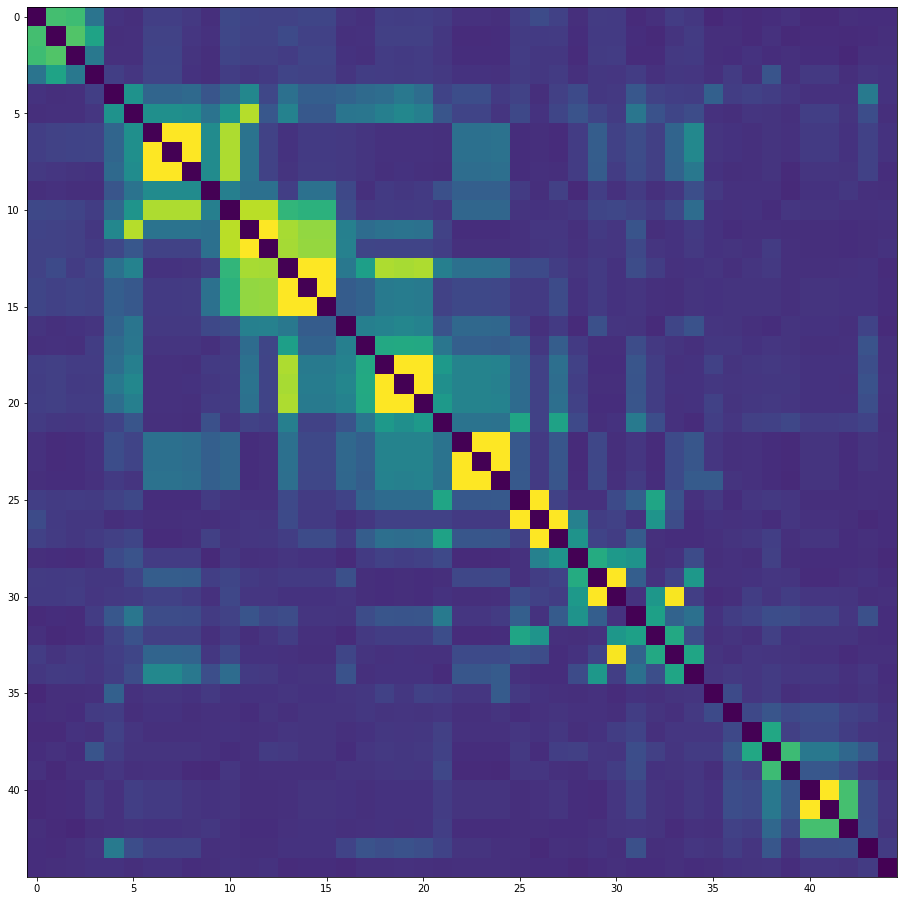

In [44]:
fig, ax = plt.subplots(figsize = (18, 16))
show = ax.imshow(sorted_mat)

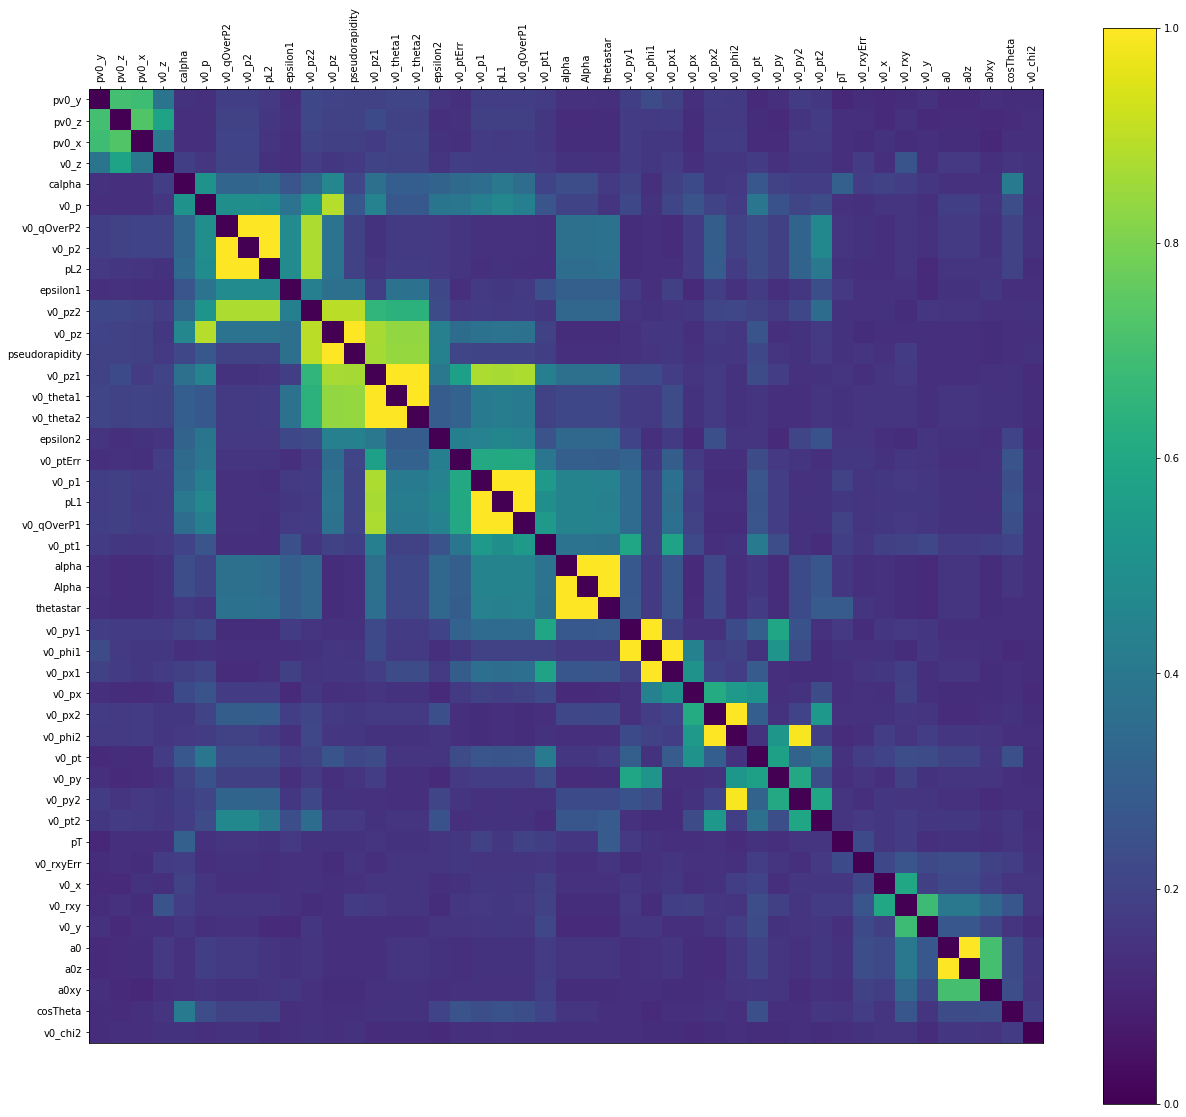

In [45]:
ax.set_xticks(np.arange(len(sort_ind)))
ax.set_xticklabels(np.array(cols)[sort_ind], rotation = 90)
ax.set_yticks(np.arange(len(sort_ind)))
ax.set_yticklabels(np.array(cols)[sort_ind])
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)
# ax.xticks(rotation = 90)

fig.colorbar(show)

fig.tight_layout()
fig

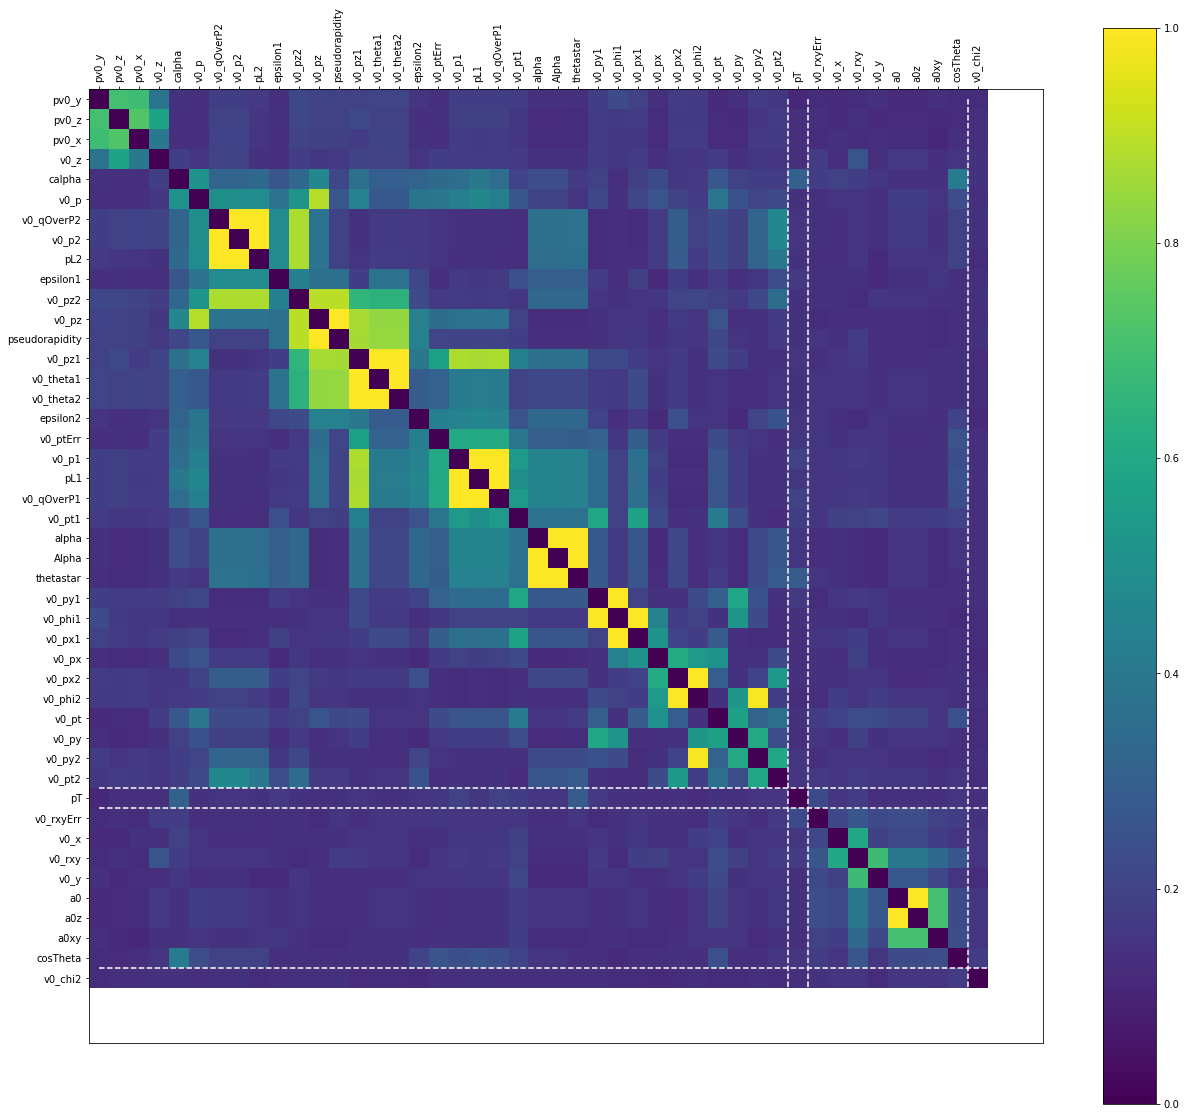

In [46]:
from scipy.cluster.hierarchy import fcluster
label = fcluster(Z,4 , criterion = "maxclust")[sort_ind]
cuts = np.arange(len(label))[(label - np.roll(label, 1) == 1)]
cuts = np.hstack([0] + list(cuts) + [len(label)])

# cuts = [0, 16, len(label)]

for line in cuts[1:-1]:#np.arange(len(label))[(label - np.roll(label, 1) == 1)] - 0.5:
        ax.hlines(line - 0.5, 0, len(sort_ind), color = 'white', linestyle = 'dashed')
        ax.vlines(line - 0.5, 0, len(sort_ind), color = 'white', linestyle = 'dashed')

# ax.hlines(5, 0, len(label), colors = 'white', linestyle = 'dashed')
fig

In [47]:
cols = np.array(cols)[sort_ind]

# cuts = [0, 16, len(cols)]
# params1 = cols[:6]
# params2 = cols[6:16]
# params3 = cols[16:]

params_list = [cols[cuts[i]:cuts[i+1]] for i in range(len(cuts) - 1)]

In [48]:
from iminuit import Minuit
from scipy.stats import norm, chi2
from AppStatFunctions import Chi2Regression, nice_string_output, add_text_to_ax
from scipy.optimize import curve_fit


def fit_data(xs, vals, errs, ax = None, guesses_bkgr = [0, 0, -10, 10000], guesses_sig = [1116, 6, 17000]):
    if not ax:
        fig, ax = plt.subplots(figsize = (16, 10), ncols = 2)
        ax_sig = ax[1]
        ax_all = ax[0]
        ax_all.plot(xs, vals, 'r.')
        ax_all.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')

 
    # The background fit 
#     def background_fit(x, scale, loc, tau):
#         return scale * np.exp(- x / tau)
    
    def background_fit(x, a, b, c, d):
        return a * (x- 1116) ** 3 + b * (x-1116) ** 2 + c * (x-1116) + d
    
    # The signal fit  Here gauss
    def add_signal(x, mean, sig, size):
        return size * norm.pdf(x, mean, sig)
    
    # The full fit
    def full_fit(x, mean, sig, size, a, b, c, d):
        return background_fit(x, a, b, c, d) + add_signal(x, mean, sig, size)
    
    # Background fit under here
    vals_b, cov_b = curve_fit(background_fit, xs, vals, p0 = guesses_bkgr)
    
    b1, b2, b3, b4 = vals_b
    
    bkgr_chi2 = Chi2Regression(background_fit, xs, vals, errs)
    bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
    
    bkgr_min.migrad()
    
    # Plot result and save guesses
    ax_all.plot(xs, background_fit(xs, *bkgr_min.args),'b--',  label = "background_fit")
    
    b1, b2, b3, b4 = bkgr_min.args
    s1, s2, s3 = guesses_sig
    
    # Full fit
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = s1, sig = s2, size = s3)
    
    full_min.migrad()
    
    s1, s2, s3, b1, b2, b3, b4 = full_min.args
    
    ax_all.plot(xs, full_fit(xs, *full_min.args), "k-", label = "full_fit")
    
    ax_all.legend(loc = "upper right")
    
    # Details:
    text = {'chi2': full_min.fval, \
            'pval': chi2.sf(full_min.fval, len(xs) - len(full_min.args)), \
            'mean': f"{full_min.values['mean']:.1f} +/- {full_min.errors['mean']:.1f}",\
            'N':    f"{full_min.values['size']:.1f} +/- {full_min.errors['size']:.1f}"}
    
    text_output = nice_string_output(text)
    add_text_to_ax(0.60, 0.925, text_output, ax_all)
    
    
    # Plot signal seperately
    ax_sig.fill_between(xs, add_signal(xs, s1, s2, s3), color = 'red', alpha = 0.5, label = "sig fit")
    
    vals_sig = vals - background_fit(xs, b1, b2, b3, b4)
    
    ax_sig.plot(xs, vals_sig, 'r.')
    ax_sig.errorbar(xs, vals_sig, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    
    sig_amount = np.sum(add_signal(xs, s1, s2, s3))
    bak_amount = np.sum(background_fit(xs, b1, b2, b3, b4))
    
    text_a = {'sig': np.round(sig_amount), \
              'bkgr': np.round(bak_amount), \
              's/b': sig_amount / bak_amount}
    
    text_output = nice_string_output(text_a, decimals = 2)
    add_text_to_ax(0.70, 0.90, text_output, ax_sig)
    
    fig.tight_layout()
    
    bak_func = lambda x: background_fit(x, b1, b2, b3, b4)
    sig_func = lambda x: add_signal(x, s1, s2, s3)
        
    return fig, ax, full_min, bak_func, sig_func, [s1, s2, s3, b1, b2, b3, b4]

In [49]:
df = data_tree.pandas.df(load_variables, entrystop = 10**6)

In [50]:
mass = df.v0_la_mass
dfs = [df.loc[:, params] for params in params_list]

In [51]:
params_list

[array(['pv0_y', 'pv0_z', 'pv0_x', 'v0_z', 'calpha', 'v0_p', 'v0_qOverP2',
        'v0_p2', 'pL2', 'epsilon1', 'v0_pz2', 'v0_pz', 'pseudorapidity',
        'v0_pz1', 'v0_theta1', 'v0_theta2', 'epsilon2', 'v0_ptErr',
        'v0_p1', 'pL1', 'v0_qOverP1', 'v0_pt1', 'alpha', 'Alpha',
        'thetastar', 'v0_py1', 'v0_phi1', 'v0_px1', 'v0_px', 'v0_px2',
        'v0_phi2', 'v0_pt', 'v0_py', 'v0_py2', 'v0_pt2'], dtype='<U14'),
 array(['pT'], dtype='<U14'),
 array(['v0_rxyErr', 'v0_x', 'v0_rxy', 'v0_y', 'a0', 'a0z', 'a0xy',
        'cosTheta'], dtype='<U14'),
 array(['v0_chi2'], dtype='<U14')]

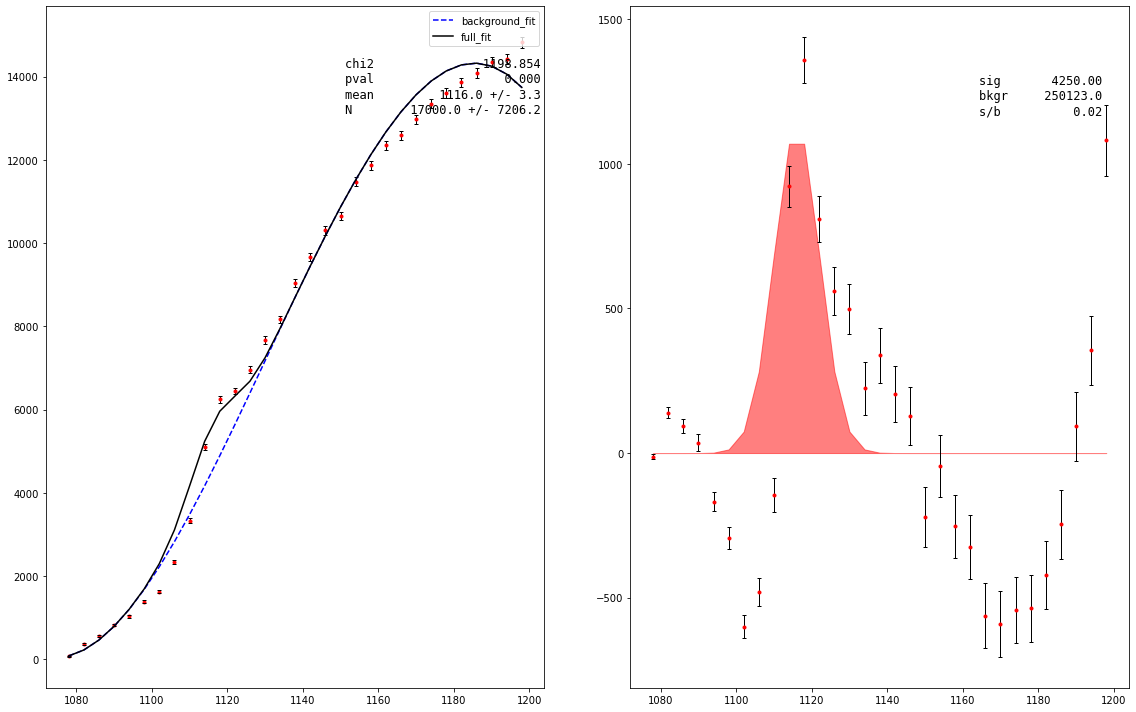

In [52]:
rang = (1000, 1200)
bins = 50

vals, edges = np.histogram(mass, range = rang, bins = bins)
xs = (edges[1:] + edges[:-1])/2

xs = xs[vals > 0]
vals = vals[vals > 0]


fig_cuts, ax_cuts, min_obj, bak, sig, varis = fit_data(xs, vals, np.sqrt(vals))

In [53]:
# Apply range
with open('models/cuts_la.dat', 'rb') as handle:
    b = pickle.load(handle)
varis=b['v0_la_mass']
cutmass = mass[(mass > 900) & (mass < 1200)]

# Take pseudo_true_sample
mean, sig = varis[0], varis[1]
pseudo_true = mass[abs(mass - mean) <  sig]

am = len(pseudo_true)

# True false
false = cutmass[abs(cutmass-mean)>4 * sig].sample(2*am)

# Make df
indicies = pd.concat([pseudo_true, false]).index

target = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target.loc[pseudo_true.index] = 1



In [54]:
from xgboost import XGBClassifier
models = []
for df in dfs:
    model = XGBClassifier()
    model.fit(df.loc[target.index, :], target)
    models.append(model)

In [55]:
probs = []
test_set = data_tree.pandas.df(load_variables, entrystart = 10**6, entrystop = 2 * 10 ** 6)
for model, params in zip(models, params_list):
    probs.append(model.predict_proba(test_set.loc[:, params])[:, 1])

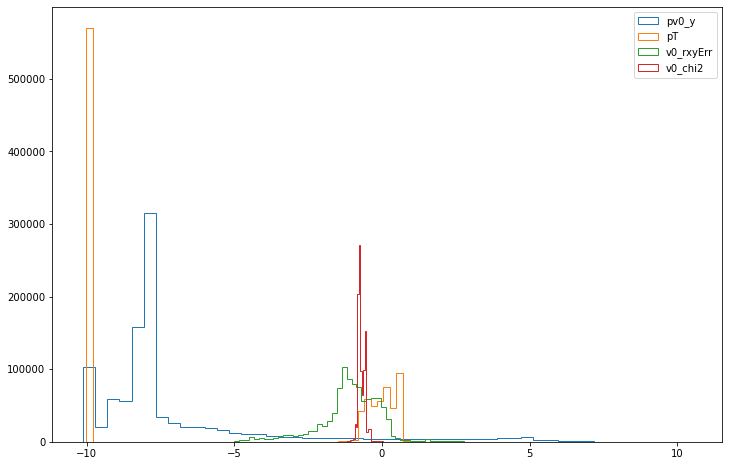

In [56]:
fig_probs, ax_probs = plt.subplots(figsize = (12, 8))

from scipy.special import logit

k=0
for prob in probs:
    ax_probs.hist(logit(prob), bins = 50, histtype = "step", label=f'{params_list[k][0]}')
    k+=1
ax_probs.legend(loc='upper right')

In [57]:
for p in probs:
    print(len(p))

1000000
1000000
1000000
1000000


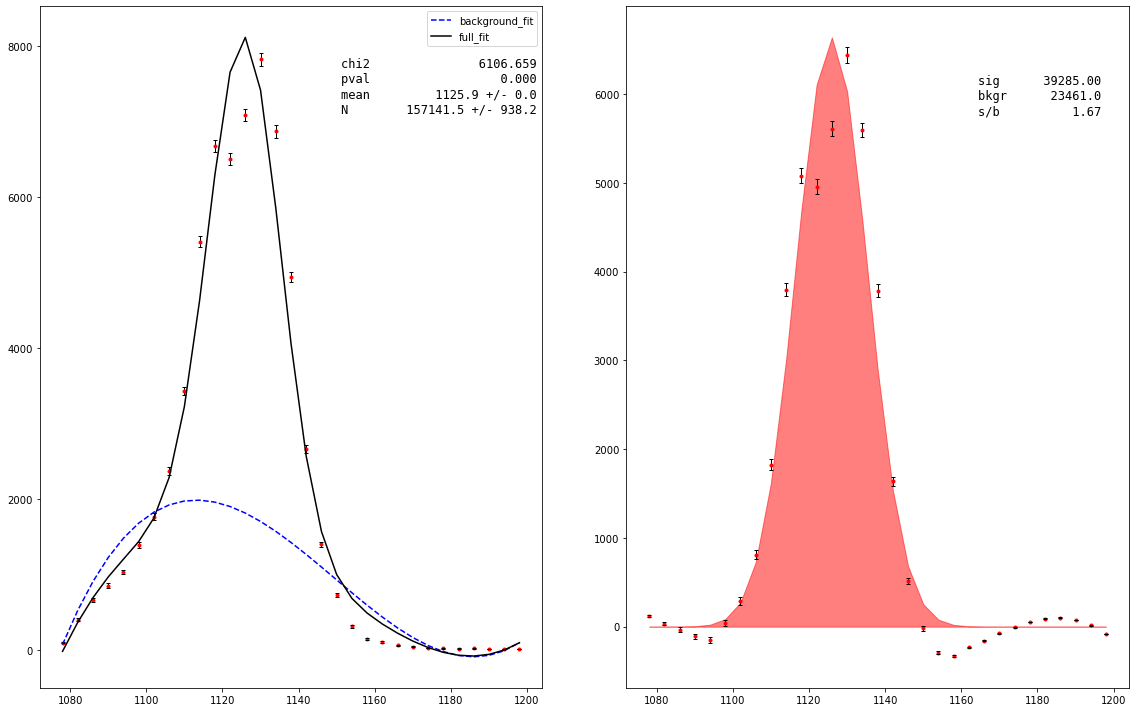

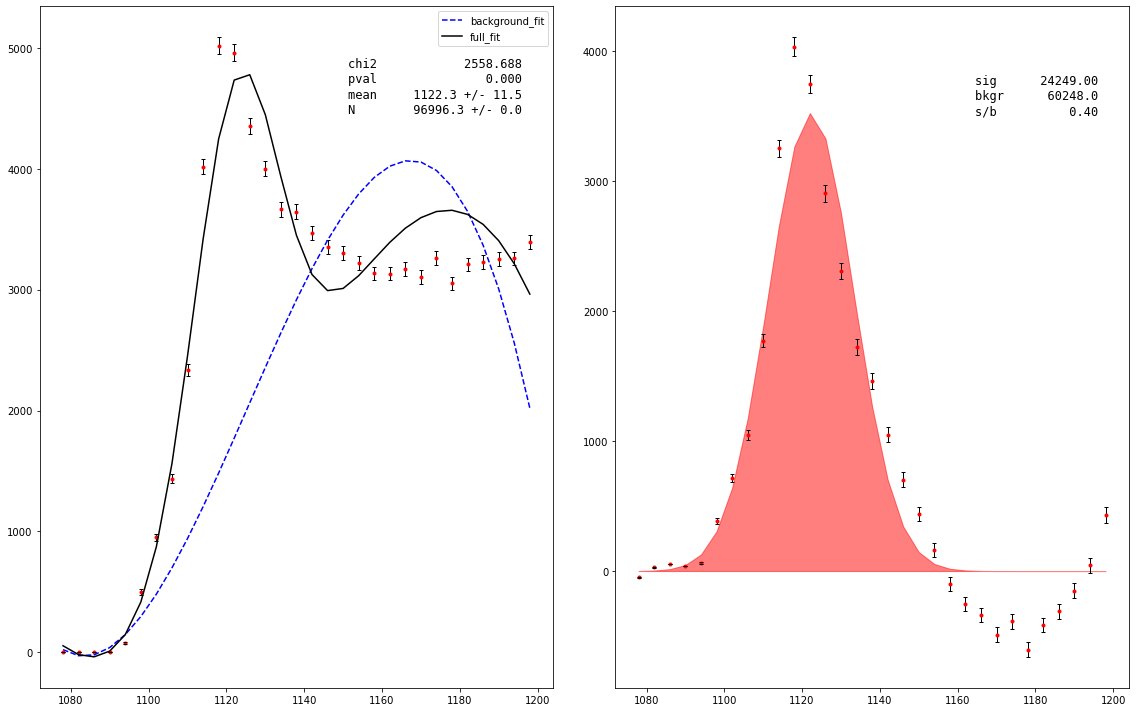

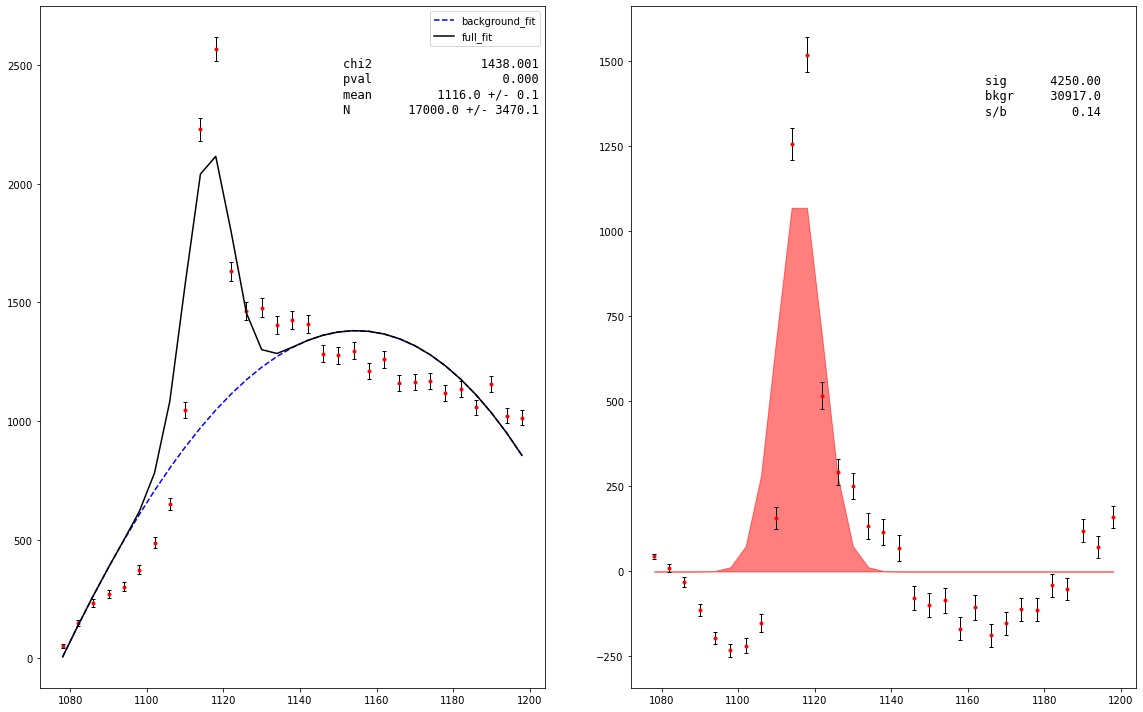

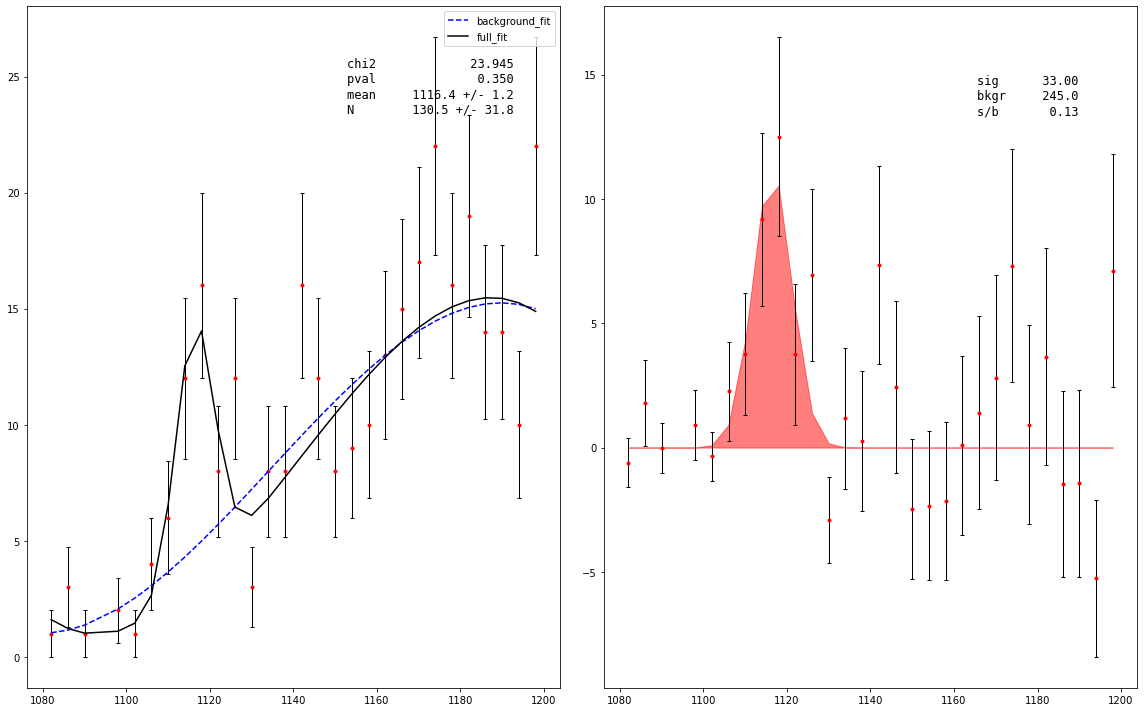

In [58]:
mass = test_set.loc[:, 'v0_la_mass']
for model, params in zip(models, params_list):
    true = mass[model.predict(test_set.loc[:, params]) == 1]
    rang = (1000, 1200)
    bins = 50

    vals, edges = np.histogram(true, range = rang, bins = bins)
    xs = (edges[1:] + edges[:-1])/2
    
    mask = vals > 0
    
    vals = vals[mask]
    xs = xs[mask]

    fit_data(xs, vals, np.sqrt(vals));

In [59]:
import py_files.functions as own
from importlib import reload

['pv0_y' 'pv0_z' 'pv0_x' 'v0_z' 'calpha' 'v0_p' 'v0_qOverP2' 'v0_p2' 'pL2'
 'epsilon1' 'v0_pz2' 'v0_pz' 'pseudorapidity' 'v0_pz1' 'v0_theta1'
 'v0_theta2' 'epsilon2' 'v0_ptErr' 'v0_p1' 'pL1' 'v0_qOverP1' 'v0_pt1'
 'alpha' 'Alpha' 'thetastar' 'v0_py1' 'v0_phi1' 'v0_px1' 'v0_px' 'v0_px2'
 'v0_phi2' 'v0_pt' 'v0_py' 'v0_py2' 'v0_pt2']
No background valid minimum found!


C:\Users\chris\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
AUC estimate = -0.9018
['pT']
No background valid minimum found!


C:\Users\chris\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
AUC estimate = -0.9018
['v0_rxyErr' 'v0_x' 'v0_rxy' 'v0_y' 'a0' 'a0z' 'a0xy' 'cosTheta']
No background valid minimum found!


C:\Users\chris\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
AUC estimate = -0.9018
['v0_chi2']
No background valid minimum found!


C:\Users\chris\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
AUC estimate = -0.9018


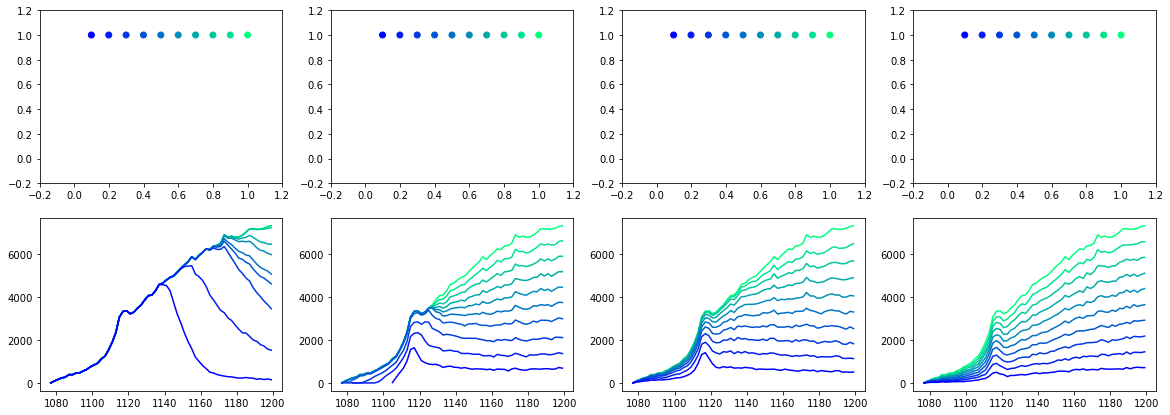

In [60]:
reload(own)
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize = (20, 7), ncols = len(probs), nrows = 2)
ax = ax.flatten()
for ax_n, prob in enumerate(probs):
    print(params_list[ax_n])
    own.roc_curve_data(mass, prob, range=(1000,1200), Npoints = 10, ax_fits = ax[ax_n + len(probs)], ax_roc = ax[ax_n], verbose = False, plimit = 0.001)
#     x, y, _ = roc_curve(label.astype(bool), 1 -  prob)
#     print(auc(x, y))
#     ax[ax_n].plot(x, y)

In [61]:
ML_corr = squareform(mp.pstats(pd.DataFrame(np.array(logit(probs))).loc[:, :1000])[0])

['pv0_y' 'pv0_z' 'pv0_x' 'v0_z' 'calpha' 'v0_p' 'v0_qOverP2' 'v0_p2' 'pL2'
 'epsilon1' 'v0_pz2' 'v0_pz' 'pseudorapidity' 'v0_pz1' 'v0_theta1'
 'v0_theta2' 'epsilon2' 'v0_ptErr' 'v0_p1' 'pL1' 'v0_qOverP1' 'v0_pt1'
 'alpha' 'Alpha' 'thetastar' 'v0_py1' 'v0_phi1' 'v0_px1' 'v0_px' 'v0_px2'
 'v0_phi2' 'v0_pt' 'v0_py' 'v0_py2' 'v0_pt2']
['pT']
['v0_rxyErr' 'v0_x' 'v0_rxy' 'v0_y' 'a0' 'a0z' 'a0xy' 'cosTheta']
['v0_chi2']


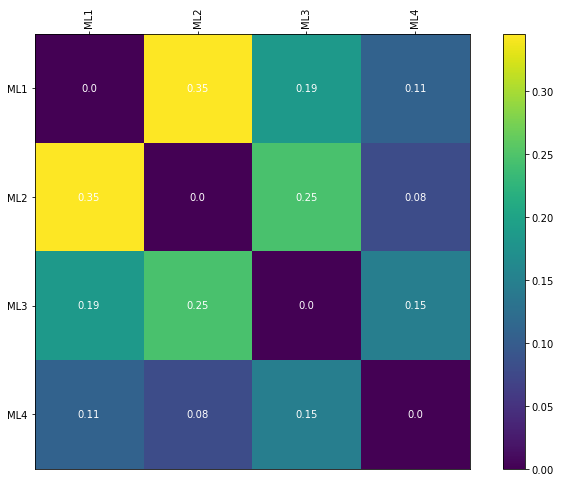

In [62]:
### from scipy.special import logit
fig, ax = plt.subplots(figsize = (12, 8))




show = ax.imshow(abs(ML_corr))

tick_labels = ["ML" + str(1 + i) for i in range(ML_corr.shape[0])]

ax.set_xticks(np.arange(ML_corr.shape[0]))
ax.set_xticklabels(tick_labels, rotation = 90)
ax.set_yticks(np.arange(ML_corr.shape[0]))
ax.set_yticklabels(tick_labels)
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)

fig.colorbar(show)

for i in range(ML_corr.shape[0]):
    for j in range(ML_corr.shape[0]):
        text = ax.text(j, i, np.round(np.array(ML_corr)[i, j], 2),
                       ha="center", va="center", color="w")
for params in params_list:
    print(params)

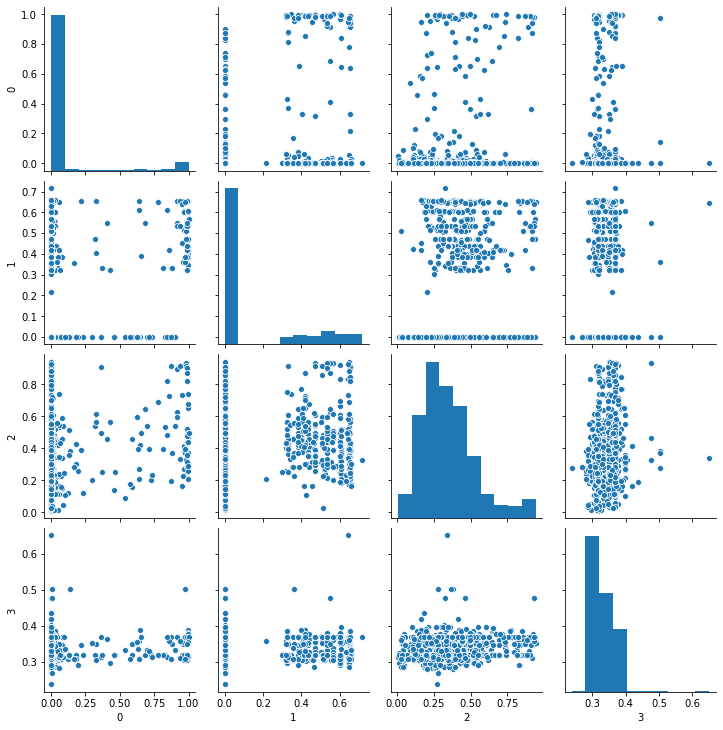

In [63]:
from seaborn import pairplot
pairplot(pd.DataFrame(np.array((probs)).T[:1000, :]))